# Projet : Classifiez automatiquement des biens de consommation

**Autor** : Louis BIRENHOLZ  
**Date** : 20/06/2020  
**Vidéo de mon projet** : https://www.youtube.com/watch?v=danhA2Vw6Os&feature=emb_logo

##  Partie 2 : Computer Vision

**Ce notebook est consacré à la partie Image & Computer Vision du projet.**

L'objectif est smiliaire à la partie texte, on utilisera cette fois les images produits pour classer les produits dans la bonne catégorie.

Dans un premier temps, après une étape de **préprocessing** sur les images, on réalisera un **Bag Of Visual Word** avec l'algorithme ORB. Le but étant de faire un clustering avec ce BoVW et de mesurer sa qualité.

On fera ensuite un **Transfer Learning** pour comparer les performances. Puis nous concluerons ce projet par une approche combinant **la partie texte** et **la partie Computer Vision**.

### Librairies

In [2]:
# Classic Lib.
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os

# PCA & Classifier.
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Computer Vision Lib.
import cv2
import PIL

# Clustering.
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Error & Quality of prediction.
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import adjusted_rand_score, silhouette_score

# Deep Learning & Transfer Learning.
import keras
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Model
from keras.layers import Dense, Flatten
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import Sequential, optimizers

### Settings

In [3]:
# Format & option.
sns.set(rc={'figure.figsize':(16,9)})
pd.options.display.max_columns = 50

# Style use.
sns.set_style('darkgrid')
plt.style.use('ggplot')

# Import Data

In [4]:
# Import the dataset.
df_product = pd.read_csv(r'C:\Users\Louis\Projet 6\df_product.csv')

In [5]:
df_product.head(4)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,product_category
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing


In [6]:
def reduce_space(a):
    """
    Cette fonction retire le dernier caractère du str en entré.
    """
    
    size = len(a)
    
    return a[:size-1]    

In [7]:
# Enlève un espace dans les str de la colonne product_category.
df_product['product_category'] = df_product['product_category'].apply(lambda x:reduce_space(x))

 **Chargement** & **Filtrage** des images

In [7]:
# Path du dossier.
folder = "C:/Users/Louis/Projet 6/Flipkart/Images"

# Liste contenant les images du dataset.
images = []

# Chargement des images en noir & blanc.
for filename in os.listdir(folder):
    
    # Path du fichier.
    path = folder + '/' + filename
    img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    
    # Filtrage Median.
    img_filtre1 = cv2.medianBlur(img, 3)

    # Filtrage Gaussien.
    img_filtre2 = cv2.GaussianBlur(img_filtre1, (5, 5), 1)
    
    # Ajout de l'image filtrée à la liste des images.
    images.append(img_filtre2)

In [ ]:
# Affichage d'une image pendant 5000 ms = 5s.
cv2.imshow('test', images[1])
cv2.waitKey(5000)
cv2.destroyAllWindows()

In [8]:
img_name = []

for j in os.listdir(folder):
    img_name.append(j)
    
df_image_order = pd.DataFrame(img_name)
df_image_order.columns = ['image']

In [222]:
# Dataframe trié par l'ordre des images.
df_product_merged = pd.merge(df_image_order, df_product, left_on = 'image', right_on = 'image')
df_product_merged2 = pd.merge(df_image_order, df_product, left_on = 'image', right_on = 'image')

# Exemple de preprocessing sur une image

Le **preprocessing** sur les images s'articule comme suit:
- Chargement des images en **niveau de gris**
- Application d'un **filtre médian**
- Application d'un **filtre Gaussien**
- Extraction des **descripteurs** de l'image par l'algo **ORB**

**ORB** performs as well as **SIFT** on the task of feature detection (and is better than SURF) while being almost two orders of magnitude faster.

In [10]:
# Chargement d'image en niveau de gris.
img1 = cv2.imread(r'C:\Users\Louis\Projet 6\rafale1.jfif', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(r'C:\Users\Louis\Projet 6\rafale2.jfif', cv2.IMREAD_GRAYSCALE)

In [11]:
# Dimension de l'image (en pixel).
img1.shape

(625, 1250)

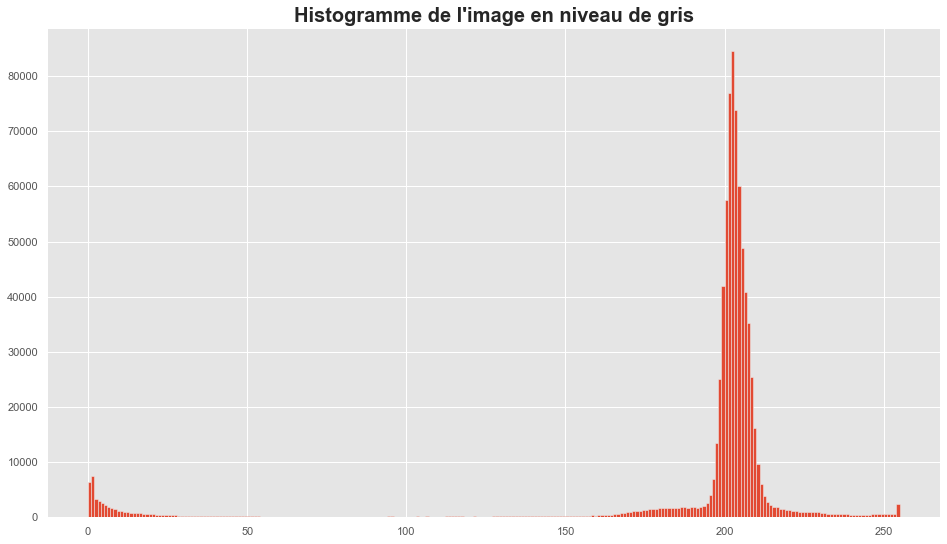

In [17]:
plt.figure(figsize=(16,9))
plt.title("Histogramme de l'image en niveau de gris", weight='bold', size=20)
n, bins, patches = plt.hist(img1.flatten(), bins=range(256))
plt.show()

In [18]:
# Affichage de l'image avant filtrage.
cv2.imshow('test', img1)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [172]:
# Filtrage Median.
img_filtre1 = cv2.medianBlur(img1, 3)

# Filtrage Gaussien.
img_filtre2 = cv2.GaussianBlur(img_filtre1, (5, 5), 1)

In [186]:
# Affichage de l'image après filtrage
cv2.imshow('test', img_filtre2)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
def keypoints(image, extractor):
    
    """
    Cette fonction retourne les keypoints de l'image donnée en entrée.
    
    """
    keypoints, descriptors = extractor.detectAndCompute(image, None)
    return keypoints

In [199]:
# On utilise ici comme extracteur l'algo ORB.
extractor = cv2.ORB_create(nfeatures=1000)

img_1 = cv2.drawKeypoints(img_filtre2, keypoints(img_filtre2, extractor), None, color=(0,255,0), flags=0)

In [200]:
# Affichage de l'image après filtrage
cv2.imshow('test', img_1)
cv2.waitKey(0)
cv2.destroyAllWindows()

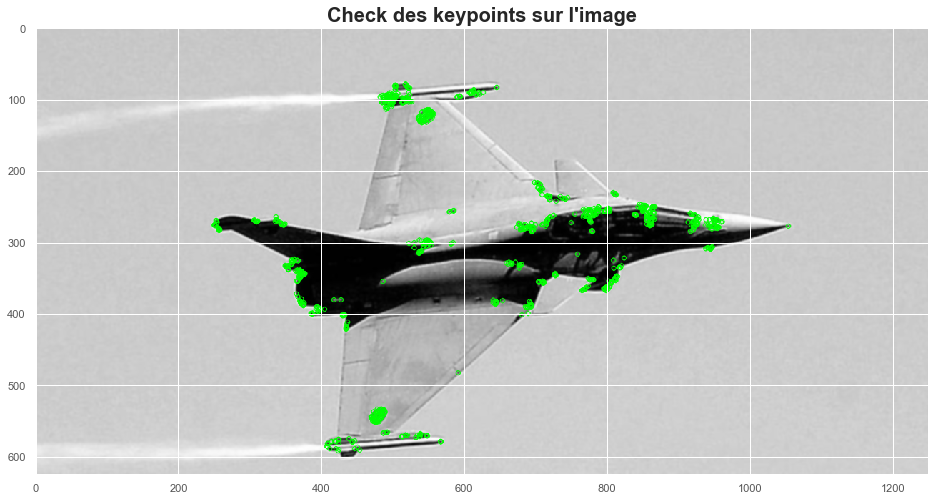

In [205]:
# Affihce de l'image après préprocessing et avec ses keypoints.
plt.title("Check des keypoints sur l'image", weight='bold', size=20)
plt.imshow(img_1)

# Bag of Visual Word

L'objectif de cette parti est d'obtenir un **training/testing set** à partir des images pour pouvoir utiliser des algos supervisés. 
On réalisera donc un **Bag of Visual Word** en utilisant l'algo **ORB**. 
On cherchera à optimiser le nombre de **Visual Word** crée en utilisé un algo de classif et en maximisant **l'accuracy_score** obtenu lors de la classification.

In [11]:
def orb_features(img):
    
    """
    Cette fonction retourne la liste des descripteurs pour chaque images.
    """
    
    # Liste contenant les descripteurs.
    descriptor = []
    
    # Extraction des descripteurs par ORB. (ici 50 descripteurs).
    orb_extractor = cv2.ORB_create(nfeatures=50)
    
    for i in img:
            
        # Keypoints & Descripteurs.
        kp, des = orb_extractor.detectAndCompute(i,None)
        descriptor.append(des)
    
    return descriptor

In [12]:
# Liste des descripteurs de l'ensemble des images.
descriptor_list = orb_features(images)

In [13]:
columns_name = [str(i) for i in range(32)]
columns_name.append('img')

In [14]:
# Réorganisation des descripteurs de chaques images du dataset.

df_courant1 = pd.DataFrame(columns=np.arange(33))
df_courant1.columns = columns_name

# Liste stockant les index des potentiels images sans descripteurs.
img_without_descriptor = []

for i,j in enumerate(descriptor_list):
    
    df_courant2 = pd.DataFrame(j)
    
    if df_courant2.shape[0]!=0:
    
        df_courant3 = pd.concat([df_courant2, pd.Series(np.full(df_courant2.shape[0],i))], axis=1)
        df_courant3.columns = columns_name

        df_courant1 = pd.concat([df_courant1, df_courant3])
    
    else:
        img_without_descriptor.append(i)

In [15]:
# Index des images n'ayant pas de descripteurs trouvés par ORB.
img_without_descriptor

[321, 513, 635, 833]

In [16]:
# Standardisation avant clustering.
S = StandardScaler()
descriptors_standard = S.fit_transform(df_courant1.iloc[:,np.arange(32)])

In [17]:
# Création des visual words via KMeans.
kmeans = KMeans(n_clusters = 750, init='k-means++')
kmeans.fit(descriptors_standard)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=750, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [27]:
df_courant1['Labels'] = kmeans.labels_

In [33]:
def complete_list(L):
    
    """
    Cette fonction complete une liste donnée en entrée avec des 0 jusqu'à avoir k éléments dans la liste.
    
    """
    
    L = list(L)
    
    while len(L)<750:
        L.append(0)
        
    return L

In [34]:
# Liste contenant le Bag of Visual Word.
bovw = []

# Création des vecteurs Bovw pour chaque image.
for i in df_courant1['img'].unique():
    bovw.append(complete_list(np.bincount(df_courant1[df_courant1['img']==i]['Labels'])))

In [35]:
df_visual_word = pd.DataFrame(bovw)

# Standardisation.
S = StandardScaler()
df_visual_word = pd.DataFrame(S.fit_transform(df_visual_word))

In [97]:
# PCA.

composantes = []
for i in range(df_visual_word.shape[1]):
    composantes.append('Principal component ' + str(i))


pca = PCA(n_components=df_visual_word.shape[1])
df_visual_word_pca = pd.DataFrame(pca.fit_transform(df_visual_word))
df_visual_word_pca.columns = composantes

In [126]:
# Combien doit-on garder de composantes principales pour expliquer 95% de la variance du dataset ?

for i,j in enumerate(pca.explained_variance_ratio_.cumsum()):
    if(j>0.95):
        print('Il faut {} composantes pour expliquer 95% de la variance du dataset'.format(i))
        break

Il faut 511 composantes pour expliquer 95% de la variance du dataset


In [127]:
# Réduction au nbr de composantes nécéssaires.
df_visual_word_pca = df_visual_word_pca.iloc[:,np.arange(511)]

# Destruction des lignes ou les produits n'ont pas de descripteur.
df_product_merged.drop(index = img_without_descriptor, inplace = True)
df_product_merged.reset_index(inplace=True, drop=True)

# Ajout de la target : product_category.
df_visual_word_pca['Category'] = df_product_merged['product_category']

C:\Users\Louis\anaconda31\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


# Test d'algo supervisé

In [55]:
# Split en training/testing set.
X_train, X_test, Y_train, Y_test = train_test_split(df_visual_word_pca.iloc[:,:df_visual_word_pca.shape[1] - 1], 
                                                    df_visual_word_pca['Category'], 
                                                    test_size=0.3)

In [56]:
# GridSearch sur la RF.
RForestClassifier = RandomForestClassifier()
gridSearch = GridSearchCV(RForestClassifier, {'max_depth': range(3,6),
                                              'n_estimators': (200,300,500)},
                                              cv=5,
                                              scoring='accuracy')
# Fit sur le training set.
gridSearch.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [57]:
# Accuracy sur l'approche supervisée.
prediction = gridSearch.best_estimator_.predict(X_test)
accuracy_score(Y_test, prediction)

0.2356687898089172

### Matrice de confusion

In [109]:
categ_unique = df_product.product_category.unique()

df_real_label_ytest = pd.DataFrame(Y_test)
df_prediction = pd.DataFrame(gridSearch.best_estimator_.predict(X_test))

df_real_label_ytest.reset_index(inplace = True, drop = True)

df_compare = pd.concat([df_real_label_ytest, df_prediction], axis=1)
df_compare.columns = ['product_category', 'prediction']

In [114]:
def dico_to_list(dico):
    
    """
    Cette fonction retourne les valeurs d'un dictionnaire sous forme d'une liste.
    
    """
    
    L=[]
    for key, value in dico.items():
        L.append(value)
    return L

In [65]:
# Création de la matrice de confusion.

df_matrice_confusion = pd.DataFrame(columns=categ_unique,index=categ_unique)

for i in categ_unique:
    
    dico ={j:0 for j in categ_unique}
    
    mask = (df_compare['product_category']==i)
    mask2 = (df_compare['product_category']!=df_compare['prediction'])
    
    dico[i] = df_compare[mask].shape[0] - df_compare[mask & mask2].shape[0]
    
    for k in df_compare[mask & mask2].prediction:
        dico[k]+=1
    
    df_matrice_confusion.loc[i,:] = dico_to_list(dico)

df_matrice_confusion = df_matrice_confusion[df_matrice_confusion.columns].astype(float)

Text(0.5, 84.453125, 'Prediction')

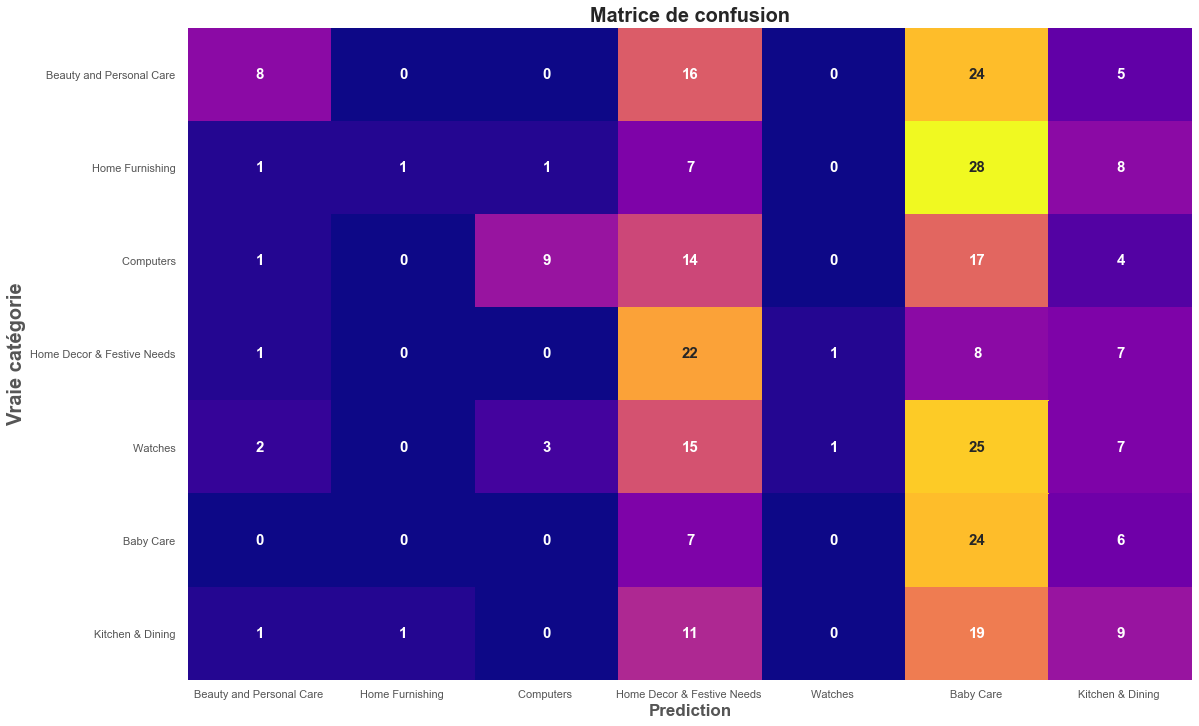

In [66]:
plt.figure(figsize=(18,12))
plt.title('Matrice de confusion', size=20, weight='bold')
sns.heatmap(df_matrice_confusion,
            xticklabels=True, 
            yticklabels= True, 
            annot=True,
            cmap="plasma", cbar=False,
            annot_kws={"size": 15, 'weight' : 'bold'})
plt.ylabel("Vraie catégorie", weight='bold', size=20)
plt.xlabel('Prediction', weight='bold', size=17)

## Clustering

In [129]:
km = KMeans(n_clusters=7, 
            init='k-means++',
            random_state=2)

km.fit(df_visual_word_pca.iloc[:,np.arange(df_visual_word_pca.shape[1]-1)])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=2, tol=0.0001, verbose=0)

In [130]:
df_visual_word_pca['Labels'] = km.labels_
df_visual_word_pca.groupby('Labels').size()

C:\Users\Louis\anaconda31\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Labels
0    117
1     47
2     95
3     78
4    140
5    226
6    343
dtype: int64

### Visualisation

Text(0.5, 1, 'Viz ACP with Kmeans')

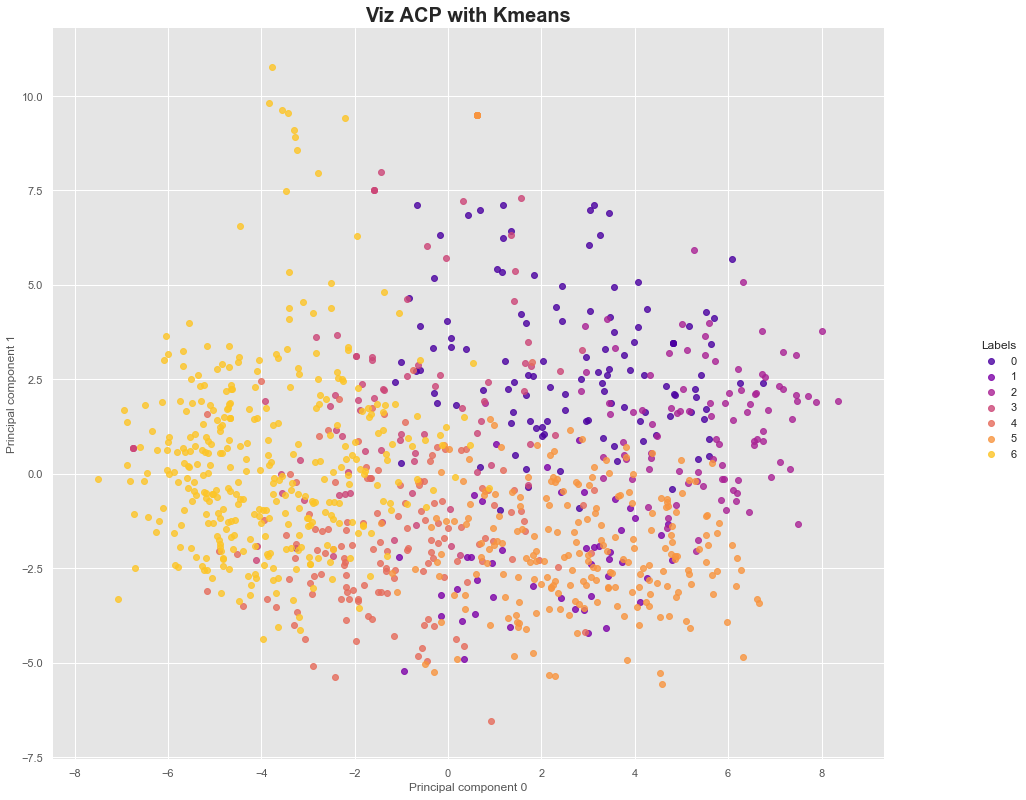

In [131]:
sns.lmplot(x='Principal component 0', 
            y='Principal component 1', 
            hue='Labels', 
            data=df_visual_word_pca,
            palette = 'plasma',
            fit_reg=False,
            legend=True, 
            legend_out=True)

plt.gcf().set_size_inches(16, 12)
plt.title('Viz ACP with Kmeans',size=20, weight='bold')

In [112]:
# Calcul des composantes TSNE.
tsne = TSNE(n_components=2, perplexity=50)
tsne_results = tsne.fit_transform(df_visual_word_pca.iloc[:,:511])

df_visual_word_pca['TSNE_2D_one'] = tsne_results[:,0]
df_visual_word_pca['TSNE_2D_two'] = tsne_results[:,1]

Text(0.5, 1, 'Viz ACP/T-Sne')

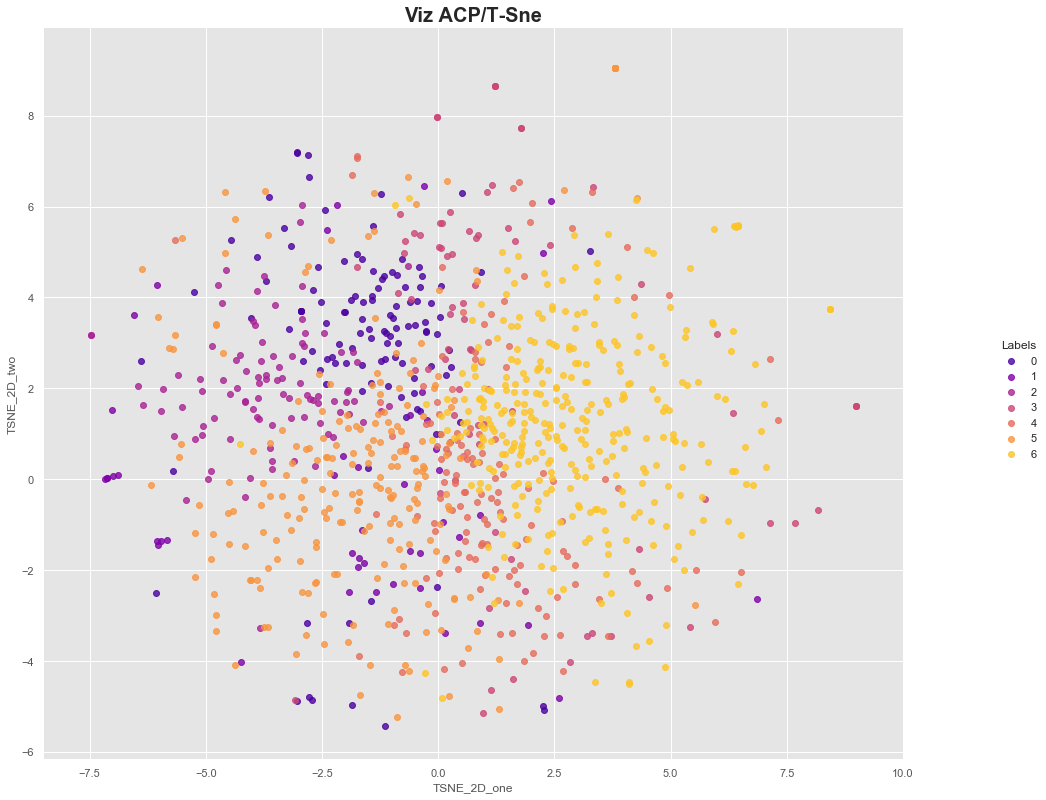

In [113]:
sns.lmplot(x='TSNE_2D_one', 
           y='TSNE_2D_two', 
           hue='Labels', 
           data=df_visual_word_pca,
           palette = 'plasma',
           fit_reg=False,
           legend=True, 
           legend_out=True)

plt.gcf().set_size_inches(16, 12)
plt.title('Viz ACP/T-Sne',size=20, weight='bold')

## Mesure de qualité du clustering

In [132]:
# Indice de Rand ajusté.
adjusted_rand_score(df_visual_word_pca.Labels, df_visual_word_pca.Category)

0.018336155954595465

In [136]:
# Coefficient de silhouette moyen.
silhouette_score(df_visual_word_pca.iloc[:,:511], df_visual_word_pca.Labels)

0.005852883388288201

# Parti Deep Learning & CNN Transfer Learning

Dans cette partie, on réalise un transfer learning via le réseau **VGG16 préentrainé** sur une base d'image **riche** (imagenet).
L'objectif est d'enlever les couches hautes du réseau pour adaptée la dernière couche **Dense** à notre problème de classficiation (7 classes).

On utilisera le **data_generator** de **Keras** pour notre training set et validation set.

## Création du training set et du validation set

In [19]:
def write_image_in_good_set(L1, L2, set_type):
    
    """
    Cette fonction charge dans le bon dossier les images associées au set spécifié (Training, Validation, Testing).
    Ce format est nécessaire pour l'utilisation du data_generator que nous utiliserons après.
    """
    
    c = 0 
    
    for i,j in zip(L1,L2):
        
        c+=1
        
        # Lecture de l'image.
        img = cv2.imread('C:/Users/Louis/Projet 6/Flipkart/Images/{}'.format(i))
        
        # Ecriture de l'image dans le dossier à la classe correspondante.
        cv2.imwrite(r'C:/Users/Louis/Projet 6/{0}/{1}/im{2}.jpg'.format(set_type, j, c), img)

In [20]:
# Split en training/testing set.
X_train, X_test, Y_train, Y_test = train_test_split(df_product.image, 
                                                    df_product.product_category, 
                                                    test_size=0.25)

# Split en training/validation set
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train,
                                                                Y_train,
                                                                test_size=0.25)


# Writting the image of the training set.
write_image_in_good_set(X_train, Y_train, 'Training Set')

# Writting images in the validation set.
write_image_in_good_set(X_validation, Y_validation, 'Validation Set')

# Writting images in the testing set.
write_image_in_good_set(X_test, Y_test, 'Testing Set')

In [ ]:
# Path du dossier.
folder = "C:/Users/Louis/Projet 6/Testing Set"

i = 0

# Liste contenant les catégories des images chargées
categ = []

for j in os.listdir(folder):
    
    folder_courant = folder + '/' + j
    
    for filename in os.listdir(folder_courant):
        
        categ.append(j)

        # Path du fichier.
        path = folder_courant + '/' + filename

        # Charger l'image à la bonne dimension.
        img_resize = load_img(path, target_size=(224, 224))

        # Transformation de l'image en tableau numpy.
        img = img_to_array(img_resize)
        img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))

        # Preprocessing.
        img = preprocess_input(img)

        # Ajout de l'image à la liste de stockage.
        if (i==0) :
            x1 = img
            i = 1
        else :
            x1 = np.concatenate((x1,img),axis=0)

## Transfer Learning

In [6]:
# Chargement de VGG16 sans les couches hautes (fully connected).
model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

x = model.output

# Ajout d'une couche Flatten pour réduire les dimensions de l'input.
x = Flatten()(x)

# Ajout de la couche Dense de prédiciton adaptée à notre problème de classifications (7 classes).
predictions = Dense(7, activation='softmax')(x)

In [7]:
# Définir le nouveau modèle
new_model = Model(inputs=model.input, outputs=predictions)

In [10]:
# On n'entrainte pas les couches les plus basses du réseau (les 10 + profondes).
for layer in new_model.layers[:10]:
    layer.trainable=False
    
# On entraine les couches hautes du réseau ainsi que le classifieur.    
for layer in new_model.layers[10:]:
    layer.trainable=True

In [102]:
# Architecture du réseau.
new_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [12]:
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [13]:
# Chargement du training set via data_generator.
train_generator = data_generator.flow_from_directory(
    r'C:\Users\Louis\Projet 6\Training Set',
    target_size=(224, 224),
    batch_size=20,
    class_mode='categorical')

Found 590 images belonging to 7 classes.


In [14]:
# Chargement du validation set via data_generator.
validation_generator = data_generator.flow_from_directory(
    r'C:\Users\Louis\Projet 6\Validation Set',
    target_size=(224, 224),
    batch_size=20,
    class_mode='categorical')

Found 197 images belonging to 7 classes.


In [15]:
# Compilation du modèle 
new_model.compile(loss="categorical_crossentropy", optimizer=optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

# Entraînement du modèle via le train_generator.
# On fait attention à l'overfitting en utilisant notre validation set.
new_model.fit_generator(train_generator,
                    epochs=5,
                    steps_per_epoch=60,
                    verbose=1, 
                    validation_data=validation_generator,
                    validation_steps=15)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
17/60 [=======>......................] - ETA: 20:06 - loss: 8.1196 - accuracy: 0.4118

C:\Users\Louis\anaconda31\lib\site-packages\PIL\Image.py:2766: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


60/60 [==============================] - 1434s 24s/step - loss: 4.4826 - accuracy: 0.5712 - val_loss: 1.0939 - val_accuracy: 0.6263
Epoch 2/5
60/60 [==============================] - 1262s 21s/step - loss: 0.5243 - accuracy: 0.8551 - val_loss: 0.2488 - val_accuracy: 0.6837
Epoch 3/5
60/60 [==============================] - 1277s 21s/step - loss: 0.1081 - accuracy: 0.9847 - val_loss: 1.5943 - val_accuracy: 0.7071
Epoch 4/5
60/60 [==============================] - 1247s 21s/step - loss: 0.0602 - accuracy: 0.9958 - val_loss: 1.7744 - val_accuracy: 0.7109
Epoch 5/5
60/60 [==============================] - 1246s 21s/step - loss: 0.0696 - accuracy: 0.9966 - val_loss: 1.9577 - val_accuracy: 0.7138


In [89]:
# Prediction sur les testing Set.
pred = new_model.predict(x1, verbose=1)

263/263 [==============================] - 229s 870ms/step


## Mesure de qualité.

In [98]:
dico_categ = {'0':'Baby Care',
             '1':'Beauty and Personal Care',
             '2':'Computers',
             '3':'Home Decor & Festive Needs',
             '4':'Home Furnishing',
             '5':'Kitchen & Dining',
             '6':'Watches'}

pred2 = []
for i in pred:
    i_list = list(i)
    pred2.append(dico_categ[str(i_list.index(max(i_list)))])

In [101]:
# Accuracy_score.
accuracy_score(categ,pred2)

0.7072243346007605

In [104]:
# Precision_score.
precision_score(categ, pred2, average='weighted')

0.7126318179074833

### Check de la matrice de confusion

In [110]:
categ_unique2 = list(categ_unique)
categ_unique2.append('Accuracy %')

df_real_label_ytest = pd.DataFrame(categ)
df_prediction = pd.DataFrame(pred2)

df_real_label_ytest.reset_index(inplace = True, drop = True)

df_compare = pd.concat([df_real_label_ytest, df_prediction], axis=1)
df_compare.columns = ['product_category', 'prediction']

NameError: name 'categ' is not defined

In [135]:
# Création de la matrice de confusion.

df_matrice_confusion = pd.DataFrame(columns=categ_unique2,index=categ_unique)

for i in categ_unique:
    
    dico ={j:0 for j in categ_unique}
    
    mask = (df_compare['product_category']==i)
    mask2 = (df_compare['product_category']!=df_compare['prediction'])
    
    dico[i] = df_compare[mask].shape[0] - df_compare[mask & mask2].shape[0]
    
    for k in df_compare[mask & mask2].prediction:
        dico[k]+=1
    
    # Transformatio en liste du dictionnaire.
    list_check_error = dico_to_list(dico)
    
    # Check de l'accuracy sur la catégorie produit en cours.
    list_check_error.append(accuracy_score(df_compare[mask].product_category,
                                           df_compare[mask].prediction)*100)
    
    df_matrice_confusion.loc[i,:] = list_check_error

df_matrice_confusion = df_matrice_confusion[df_matrice_confusion.columns].astype(float)

Text(0.5, 87.0, 'Prediction')

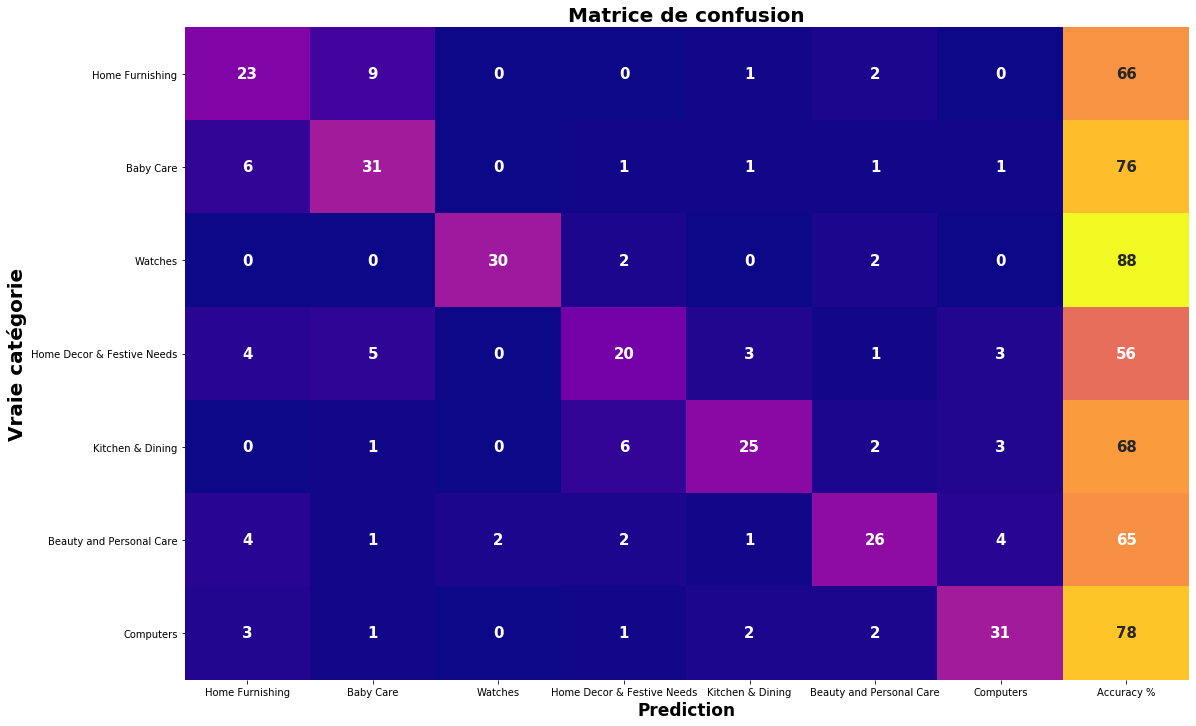

In [136]:
plt.figure(figsize=(18,12))
plt.title('Matrice de confusion', size=20, weight='bold')
sns.heatmap(df_matrice_confusion,
            xticklabels=True, 
            yticklabels= True, 
            annot=True,
            cmap="plasma", cbar=False,
            annot_kws={"size": 15, 'weight' : 'bold'})
plt.ylabel("Vraie catégorie", weight='bold', size=20)
plt.xlabel('Prediction', weight='bold', size=17)

# Combinaison de l'approche texte et de l'approche image (CNN)

**L'objectif** de cette dernière partie est de combiner **l'approche NLP** des descriptions produits et **la partie Computer Vision** des images produits.

On utilisera le **VGG16 préentrainé sur ImageNet** pour faire de l'extraction de feature. On concatenera ensuite le dataset obtenu avec le BoW. On appliquera un RandomForestClassifier pour **mesurer les performances** (accuracy_score, precision_score...)

In [74]:
# Chargement du BoW (resultant de l'analyse de la partie texte).
df_bow = pd.read_csv(r'C:\Users\Louis\Projet 6\df_bow.csv')
df_bow.columns = ['Feature BoW {}'.format(i) for i in range(100)] + ['product_category', 'img_id']

In [ ]:
# Path du dossier.
folder = "C:/Users/Louis/Projet 6/Flipkart/Images"
 
x_scratch = []
name_img = []

# Boucle pour charger les images.
for img in os.listdir(folder):
    
    # Path.
    imagePath = folder + '/' + img
    
    name_img.append(img)

    # Chargement des images et sizing à 224*224 pixels.
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)

    # Preprocessing adapté à l'utilisation de VGG16.
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)

    x_scratch.append(image)

x = np.vstack(x_scratch)

In [8]:
# Chargement de VGG16 sans les couches hautes (fully connected).
model_features_extraction = VGG16(weights="imagenet", include_top=False)

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
# Extraction des features.
features = model_features_extraction.predict(x, batch_size=5, verbose=1)
features_flatten = features.reshape((features.shape[0], 7 * 7 * 512))

1050/1050 [==============================] - 684s 651ms/step


In [19]:
# Standardisation avant clustering.
S = StandardScaler()
extraction_features_standard = S.fit_transform(features_flatten)

In [48]:
# PCA.
pca = PCA(n_components=1049)
df_features_extraction_pca = pd.DataFrame(pca.fit_transform(extraction_features_standard))

In [49]:
# On renomme les colonnes.
df_features_extraction_pca.columns = ['Principal Component {}'.format(i) for i in range(1049)]

In [54]:
df_features_extraction_pca = pd.concat([df_features_extraction_pca.iloc[:,:150], pd.DataFrame(name_img)], axis=1)

In [88]:
df_combined = pd.merge(df_features_extraction_pca, df_bow, 
                       left_on=0, right_on='img_id')
del df_combined[0]

In [92]:
# Split en training/testing set.
X_train, X_test, Y_train, Y_test = train_test_split(df_combined.iloc[:,:250], 
                                                    df_combined.product_category, 
                                                    test_size=0.3)

In [100]:
# GridSearch sur la RF.
RForestClassifier = RandomForestClassifier()
gridSearch = GridSearchCV(RForestClassifier, {'max_depth': range(3,6),
                                              'n_estimators': (300,500,750,1000)},
                                              cv=5,
                                              scoring='accuracy')
# Fit sur le training set.
gridSearch.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [102]:
prediction = gridSearch.best_estimator_.predict(X_test)

### Check des performances

In [103]:
# Accuracy.
accuracy_score(Y_test, prediction)

0.8444444444444444

In [104]:
# Precision.
precision_score(Y_test, prediction, average='weighted')

0.8526742243296012

### Matrice de confusion

In [150]:
df_real_label_ytest = pd.DataFrame(Y_test)
df_prediction = pd.DataFrame(prediction)

df_real_label_ytest.reset_index(inplace = True, drop = True)

df_compare = pd.concat([df_real_label_ytest, df_prediction], axis=1)
df_compare.columns = ['product_category', 'prediction']

In [151]:
# Création de la matrice de confusion.
categ_unique = df_compare.product_category.unique()
df_matrice_confusion = pd.DataFrame(columns=categ_unique2,index=categ_unique)

for i in categ_unique:
    
    dico ={j:0 for j in categ_unique}
    
    mask = (df_compare['product_category']==i)
    mask2 = (df_compare['product_category']!=df_compare['prediction'])
    
    dico[i] = df_compare[mask].shape[0] - df_compare[mask & mask2].shape[0]
    
    for k in df_compare[mask & mask2].prediction:
        dico[k]+=1
    
    # Transformatio en liste du dictionnaire.
    list_check_error = dico_to_list(dico)
    
    # Check de l'accuracy sur la catégorie produit en cours.
    list_check_error.append(accuracy_score(df_compare[mask].product_category,
                                           df_compare[mask].prediction)*100)
    
    df_matrice_confusion.loc[i,:] = list_check_error

df_matrice_confusion = df_matrice_confusion[df_matrice_confusion.columns].astype(float)

Text(0.5, 84.453125, 'Prediction')

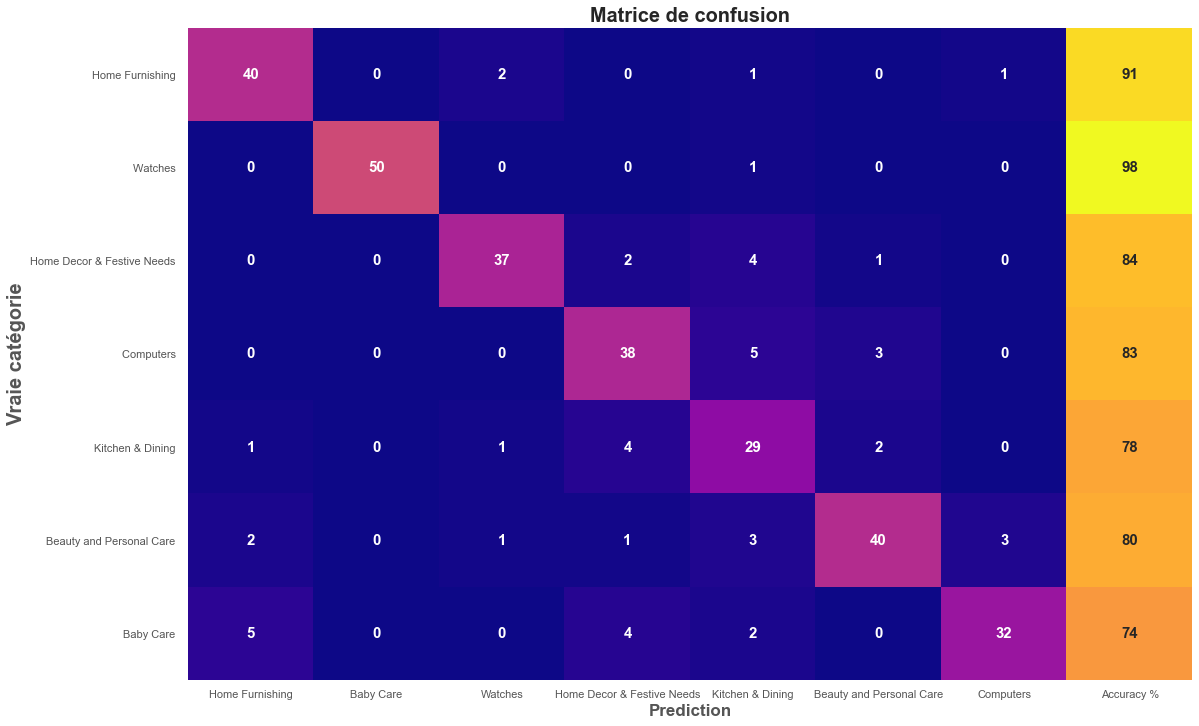

In [153]:
plt.figure(figsize=(18,12))
plt.title('Matrice de confusion', size=20, weight='bold')
sns.heatmap(df_matrice_confusion,
            xticklabels=True, 
            yticklabels= True, 
            annot=True,
            cmap="plasma", cbar=False,
            annot_kws={"size": 15, 'weight' : 'bold'})
plt.ylabel("Vraie catégorie", weight='bold', size=20)
plt.xlabel('Prediction', weight='bold', size=17)

## Conclusion sur le projet

Finalement, l'approche **stackée** entre NLP et Computer Vision donne de très bon résultat de classification. Le modèle donne de **bonnes performances** sur l'ensemble des classes (cf **matrice de confusion**) et l'approche combinée permet de moduler les faiblesses des 2 approches.

**Les recommandations :**

- Caper la description du vendeur entre une **valeur min** et un **valeur max** pour catcher au mieux les key words.
- Exiger des photos d'une certaine qualité
- Enrichir notre base de données
- Avoir une approche combinée NLP + CV.